In [9]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pickle, glob, yaml, string

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
from beamcals.sites import site

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/home/ln267/newburghlabdrone/analysis/amppickles/'


In [3]:
def get_flightinfo(fly):
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    elif whstat=='mednoabs':
        stat = np.nanmedian(diff_flat)
    return stat

In [4]:

def get_slice(beam,Z,val,ax='x'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[0,1,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[0,:,0])
    ok = True
    while(ok):
        if ax=='x':
            col = np.where((beam.x_centers_grid[0,:,0] < val+tol) & (beam.x_centers_grid[0,:,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        if ax=='y':
            col = np.where((beam.y_centers_grid[:,0,0] < val+tol) & (beam.y_centers_grid[:,0,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=3
        if tol > 30: ok = False
    return col

def get_slice_anyin(LX,LY,val,ax='x'):
    tol = abs(LX[0,1] - LX[0,0])/1.5
    if ax=='x':
        col = np.where((LX[0,:] < val+tol) & (LX[0,:] > val-tol))[0][0]
    if ax=='y':
        col = np.where((LY[:,0] < val+tol) & (LY[:,0] > val-tol))[0][0]
    return col

In [5]:
with open('/home/ln267/newburghlabdrone/analysis/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
print(pcklarr)

#LX,LY = np.meshgrid(np.linspace(-100,100,res), np.linspace(-100,100,res))


# FREQUENCY DEFAULT:
find=896#640#896#992#900#570#800#900
f_intern = int((find-512)/16)
print(freqs[find])
print(flights)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# MASK DEFAULTS #
high = 20 # inner mask, 20 for large flights
low = -20 # inner mask, 20 for large flights
maskin = high # annulus mask, set equal to high
maskout = 40 # annulus mask, 50 for large flights

# STATISTICS RANGE #
nss = np.arange(0.1,3.0,0.001) 

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

['FLY533_20210826T182904Z_ver_20230412T211305_concat.pkl'
 'FLY534_20210826T185621Z_ver_20230412T212230_concat.pkl'
 'FLY535_20210826T192056Z_ver_20230412T213957_concat.pkl'
 'FLY536_20210826T195003Z_ver_20230413T105756_concat.pkl'
 'FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl'
 'FLY619_20211021T185805Z_ver_20230412T222348_concat.pkl'
 'FLY620_20211021T192212Z_ver_20230412T224334_concat.pkl'
 'FLY623_20211021T203206Z_ver_20230412T230820_concat.pkl'
 'FLY625_20211021T214028Z_ver_20230412T232657_concat.pkl'
 'FLY646_20211022T183659Z_ver_20230412T234457_concat.pkl'
 'FLY647_20211022T185749Z_ver_20230413T000337_concat.pkl'
 'FLY648_20211022T191922Z_ver_20230413T002159_concat.pkl'
 'FLY649_20211022T194308Z_ver_20230413T003934_concat.pkl']
450.0
['533', '534', '535', '536', '618', '619', '620', '623', '625', '646', '647', '648', '649']


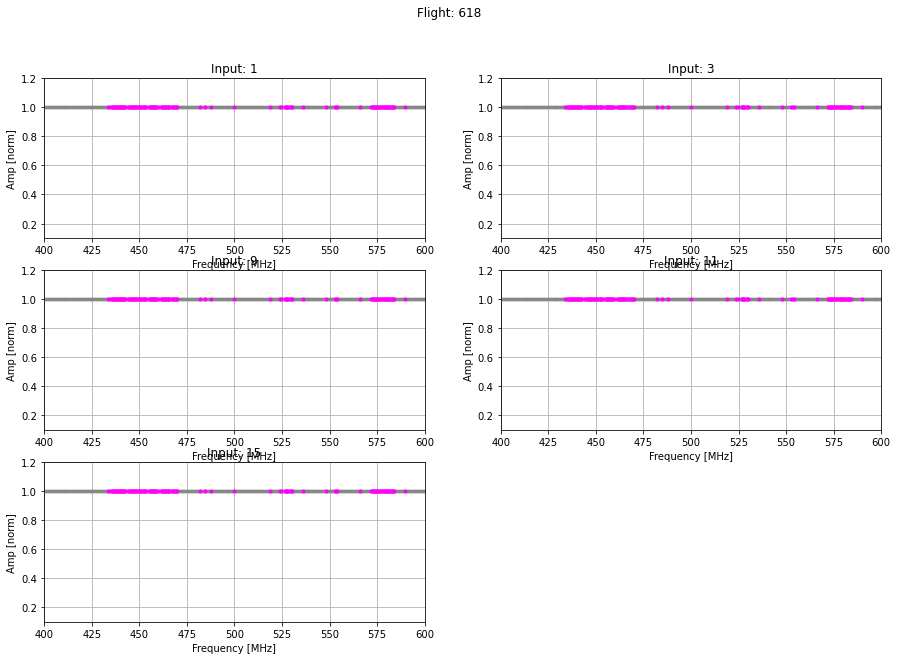

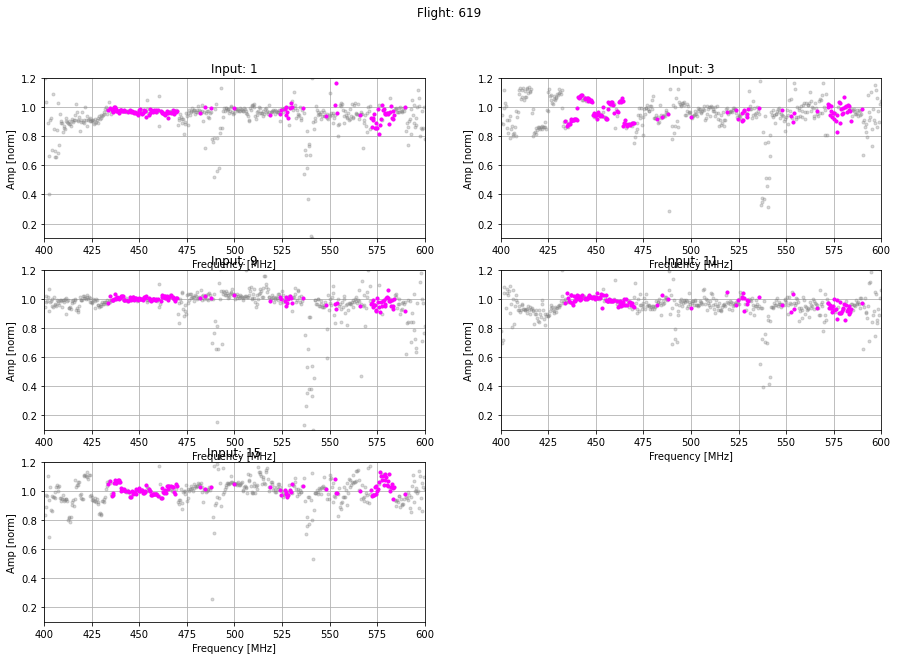

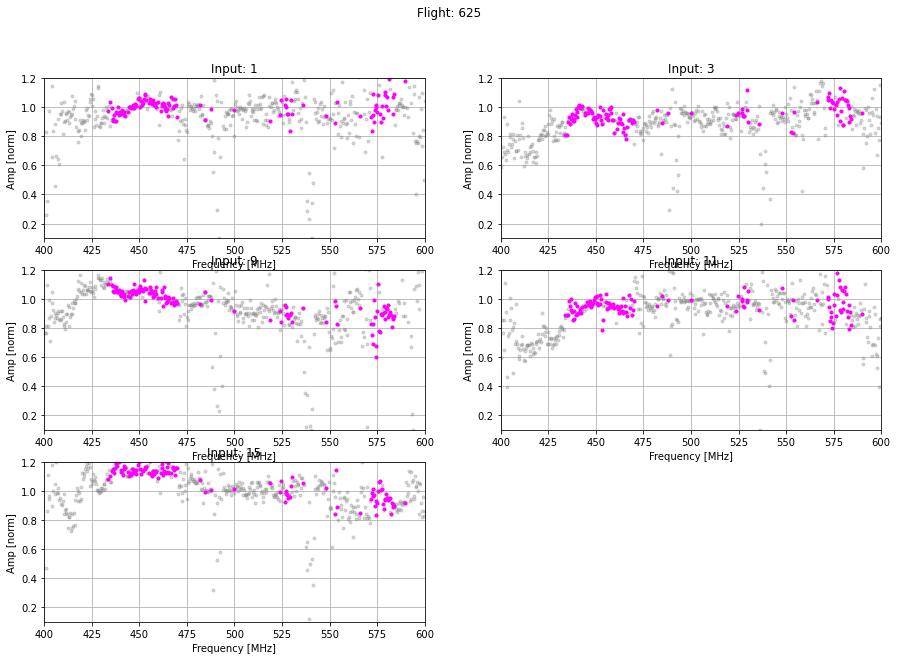

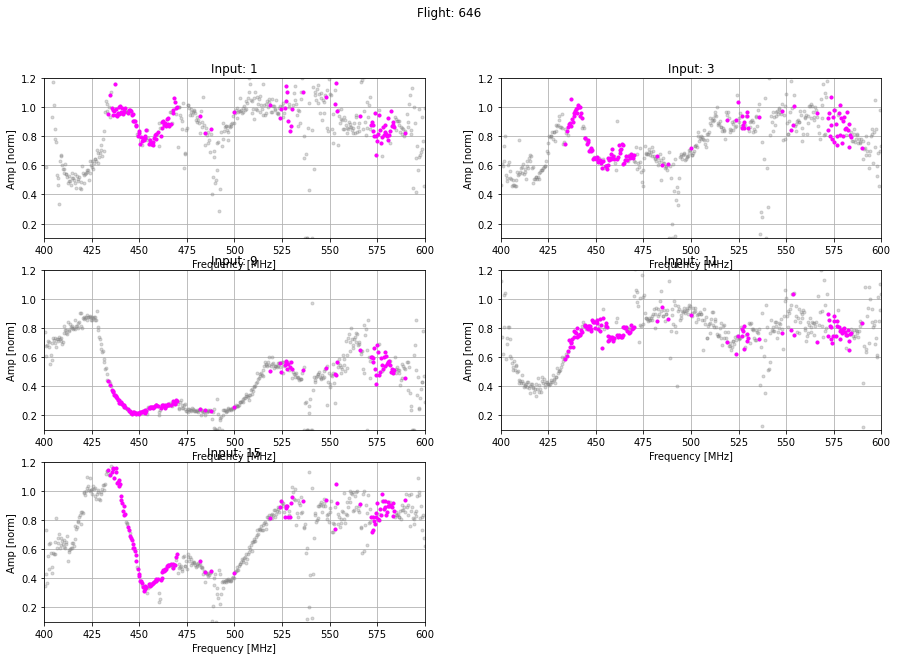

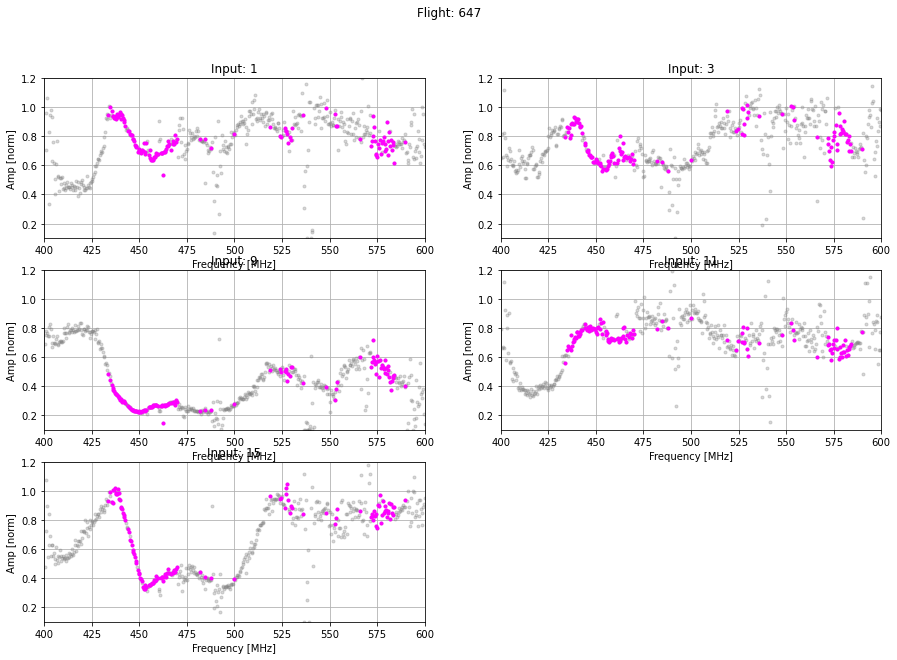

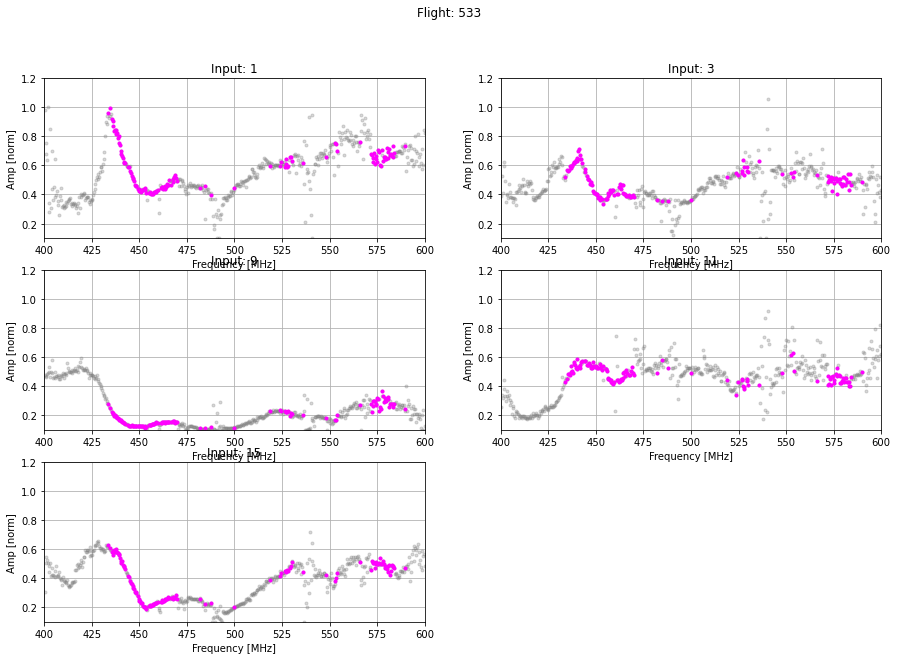

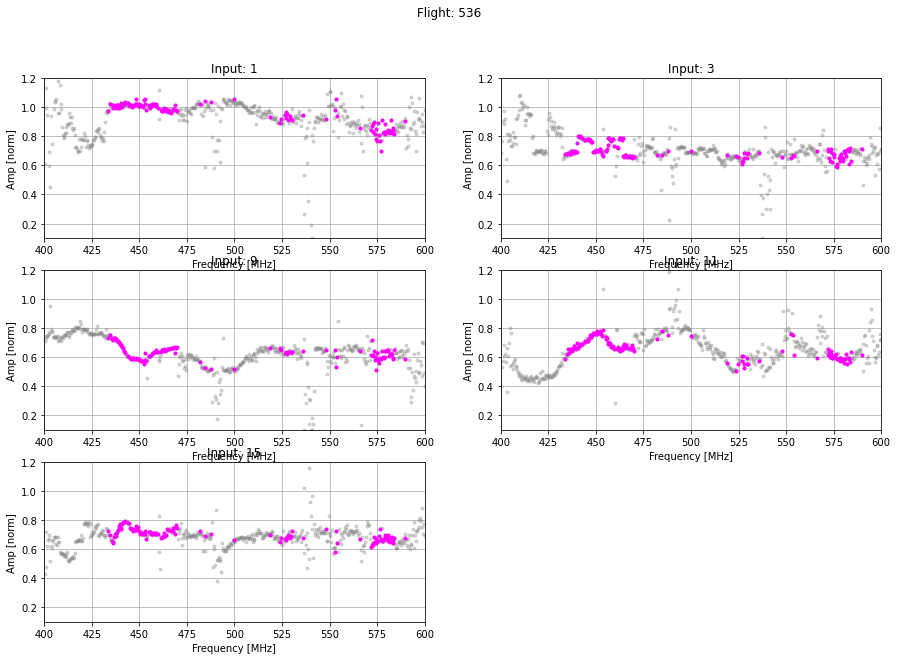

In [33]:
# Read in amplitude pickles, generate an uber-pickle file per flight, with axis [dish, frequency]


# Start with N pols - I'll plot only the good frequencies but write them all out to a main pickle
pols = N_pols

for fly in Npolflights:
    amps = np.zeros([1024,16]) # stat [best amp value from median, median value at min, best from stdd, best from mean], freq, dish

    if fly=='618': amps[:,N_pols] = 1.0
    else:
        apkls = glob.glob(ampdir+'*618*'+fly+'*')
        for apkl in apkls:
            with open(apkl, 'rb') as inp:
                ampdata = pickle.load(inp)
            gfs = np.where(ampdata[0,:,pols[0]] != 0)
            amps[gfs,:] = ampdata[0,gfs,:]
    fig = plt.figure(figsize=(15,10))
    for j,chind in enumerate(pols):
        plt.subplot(3,2,j+1)
        plt.plot(freqs,amps[:,chind],color='grey',marker='.',alpha=0.3,linestyle='none')
        plt.plot(freqs[good_freqs],amps[good_freqs,chind],color='magenta',marker='.',linestyle='None')
        plt.xlim(400,600)
        plt.ylim(0.1,1.2)
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Amp [norm]')
        plt.grid()
        plt.title('Input: '+str(chind))
    plt.suptitle('Flight: '+fly)
    plt.show()
    
    temppath = ampdir+'Corrected_amplitudes_flight_'+fly+'.pkl'
    with open(temppath, 'wb') as outp:
        pickle.dump(amps, outp, pickle.HIGHEST_PROTOCOL)
        

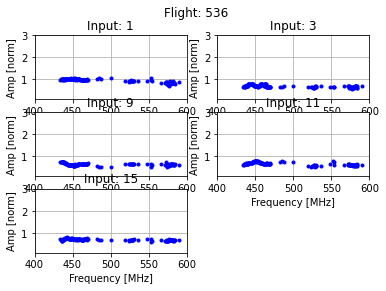

In [21]:
with open(temppath, 'rb') as inp:
    ptest = pickle.load(inp)

for j,chind in enumerate(pols):
    plt.subplot(3,2,j+1)
    plt.plot(freqs[good_freqs],ptest[good_freqs,chind],'b.')
    plt.xlim(400,600)
    plt.ylim(0.1,3.0)
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Amp [norm]')
    plt.grid()
    plt.title('Input: '+str(chind))
plt.suptitle('Flight: '+fly)
plt.show()

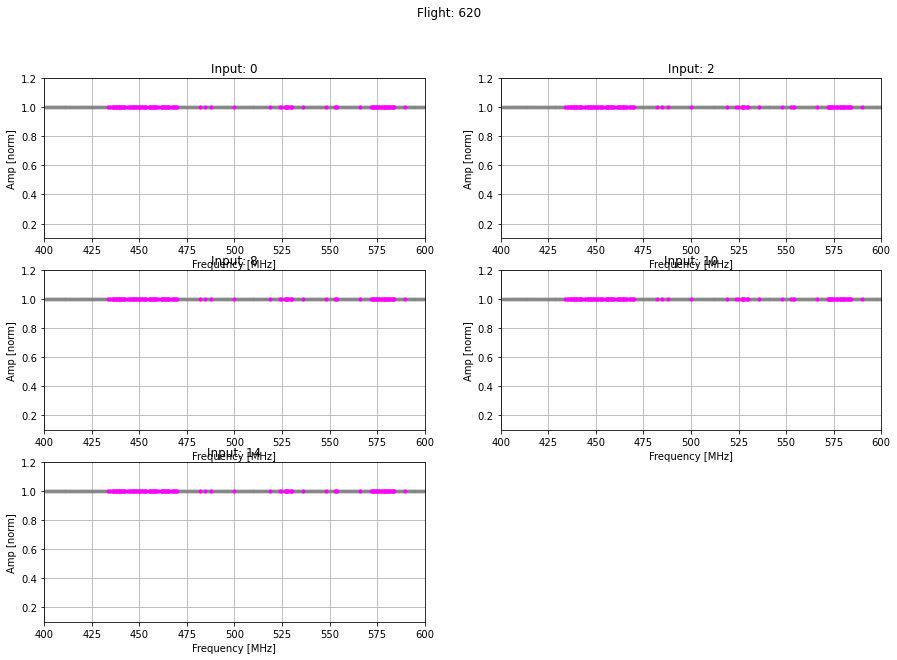

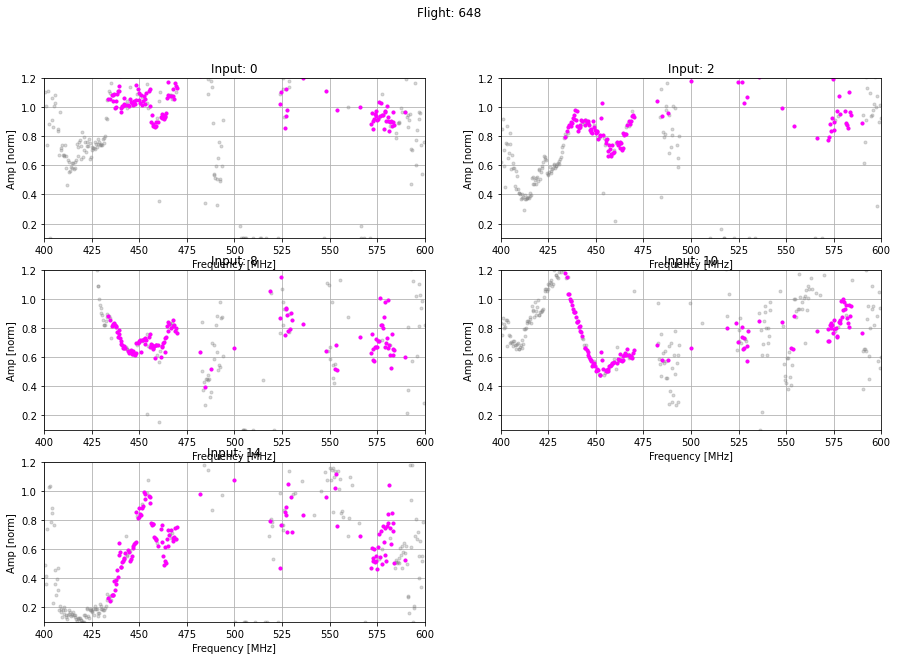

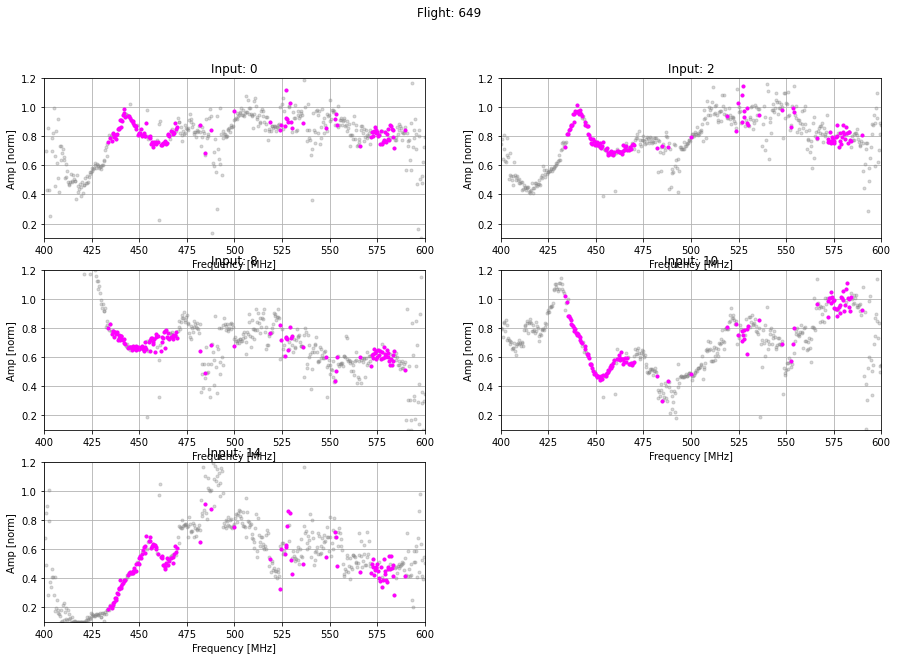

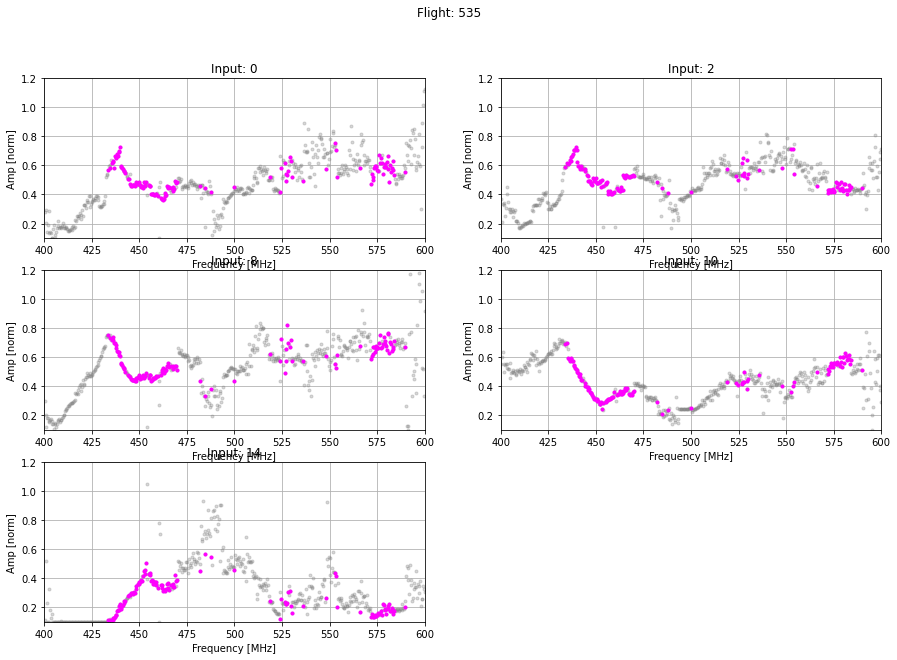

In [34]:
pols = E_pols

for fly in Epolflights:
    amps = np.zeros([1024,16]) # stat [best amp value from median, median value at min, best from stdd, best from mean], freq, dish

    if fly=='620': amps[:,E_pols] = 1.0
    else:
        apkls = glob.glob(ampdir+'*620*'+fly+'*')
        for apkl in apkls:
            with open(apkl, 'rb') as inp:
                ampdata = pickle.load(inp)
            gfs = np.where(ampdata[0,:,pols[0]] != 0)
            amps[gfs,:] = ampdata[0,gfs,:]
    fig = plt.figure(figsize=(15,10))
    for j,chind in enumerate(pols):
        plt.subplot(3,2,j+1)
        plt.plot(freqs,amps[:,chind],color='grey',marker='.',alpha=0.3,linestyle='none')
        plt.plot(freqs[good_freqs],amps[good_freqs,chind],color='magenta',marker='.',linestyle='None')
        plt.xlim(400,600)
        plt.ylim(0.1,1.2)
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Amp [norm]')
        plt.grid()
        plt.title('Input: '+str(chind))
    plt.suptitle('Flight: '+fly)
    plt.show()
    
    temppath = ampdir+'Corrected_amplitudes_flight_'+fly+'.pkl'
    with open(temppath, 'wb') as outp:
        pickle.dump(amps, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Initial frequency selection, to decide which frequencies to plot slices of:
# Read in the amplitude pickles, select based on high median values, 
# amplitudes that bottomed out, or amplitudes that are too high

In [82]:

# lets tally the frequencies we don't want to use
Nbadfreqs = []
Ebadfreqs = []

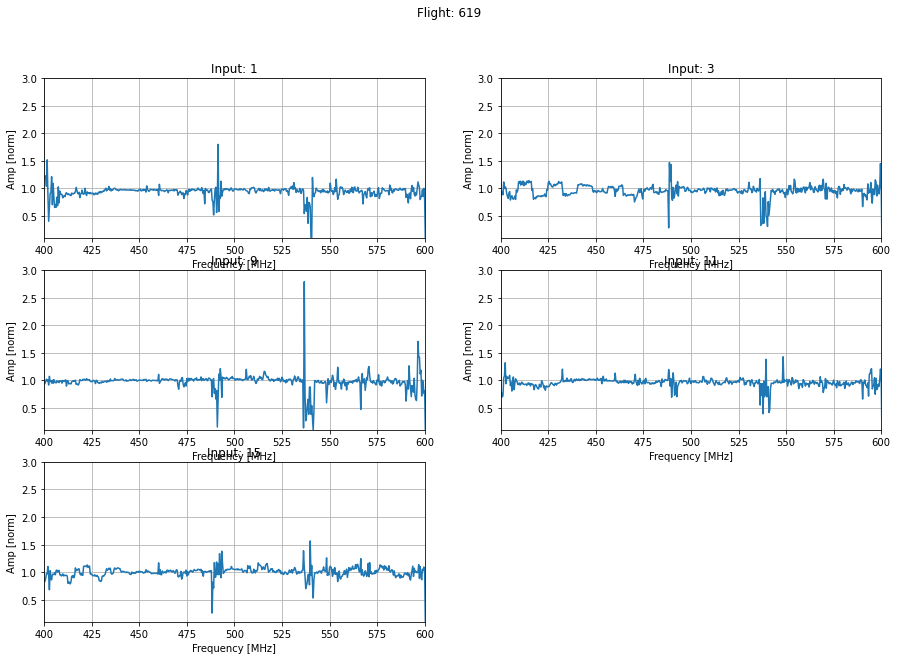

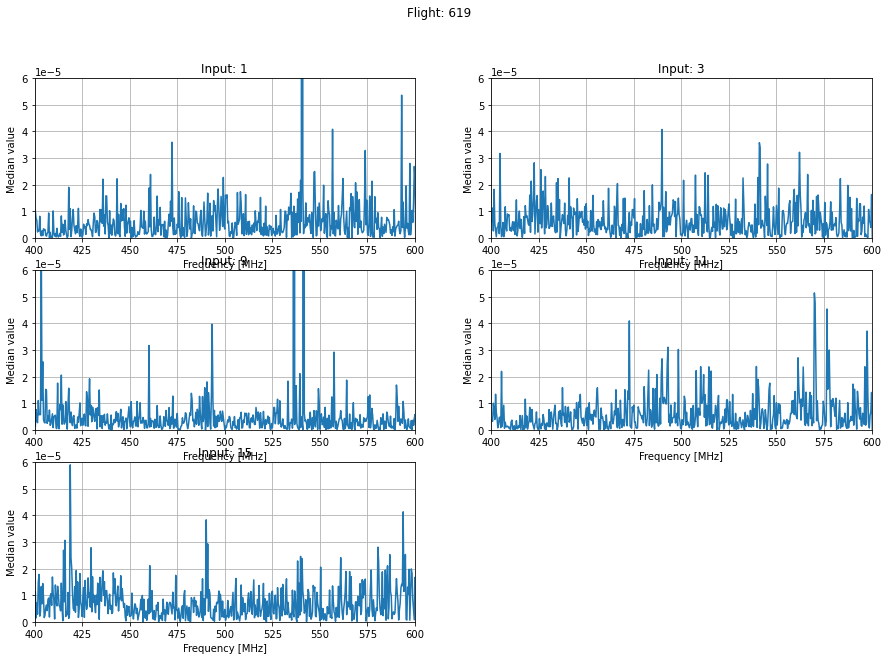

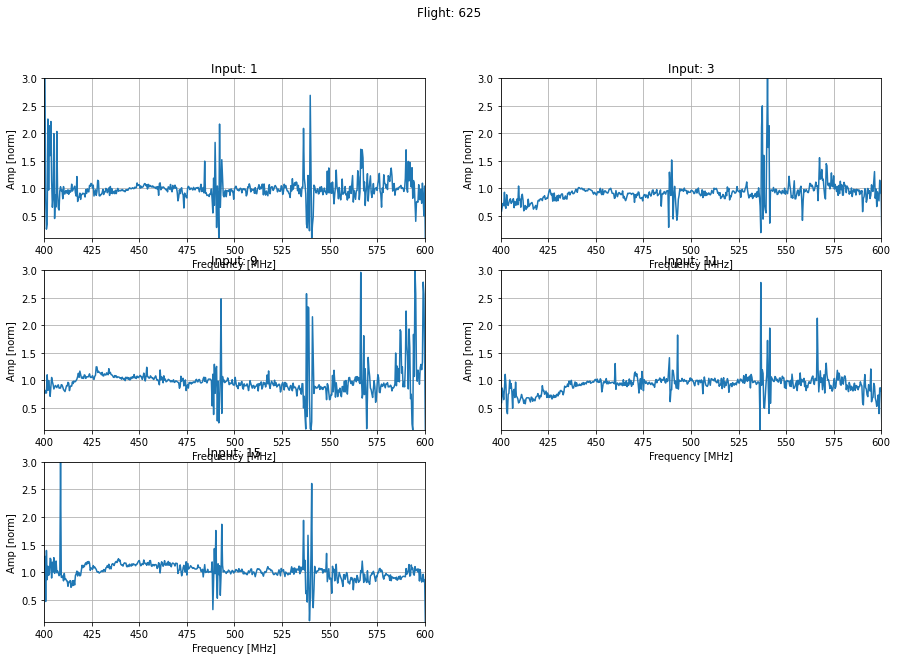

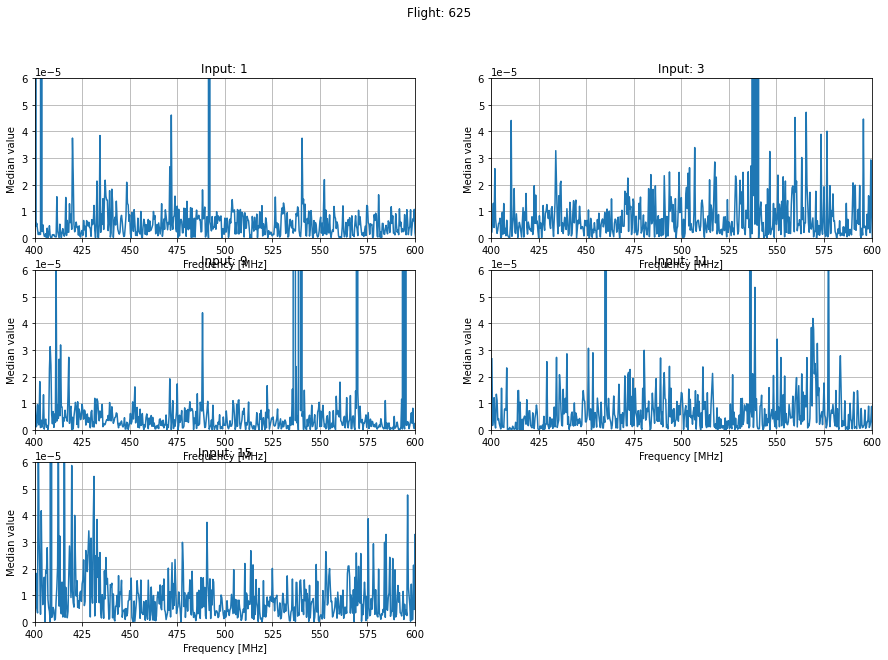

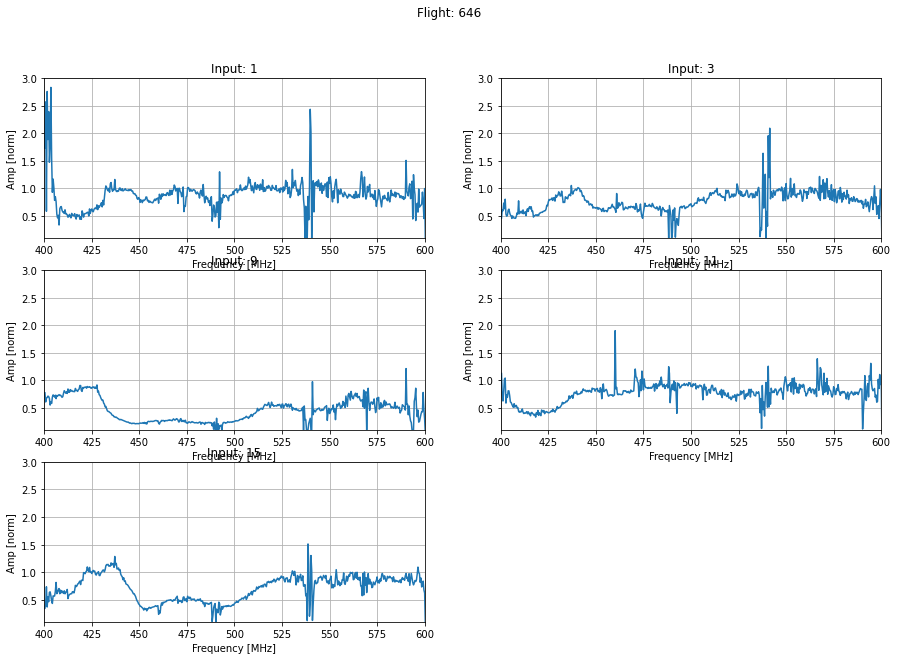

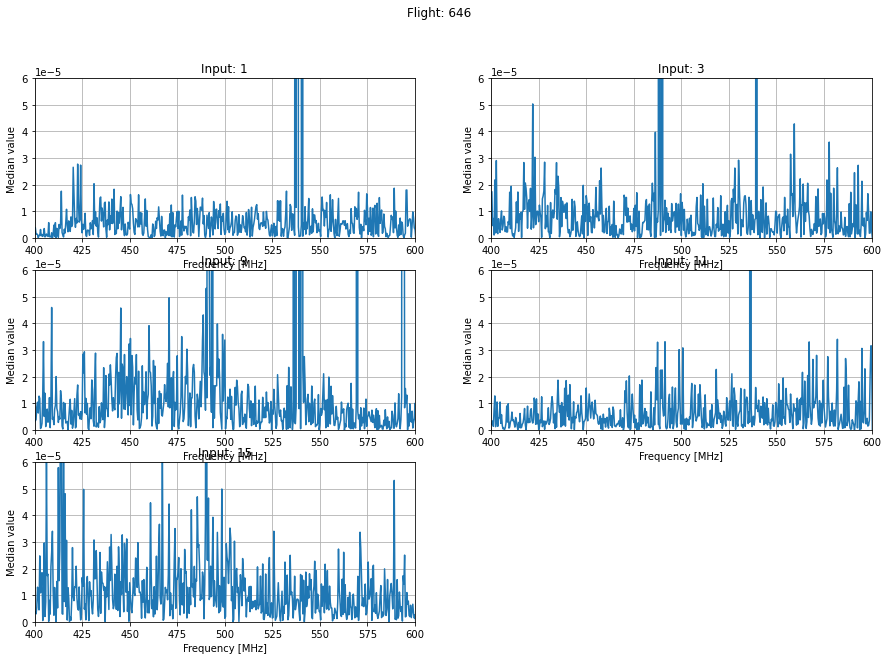

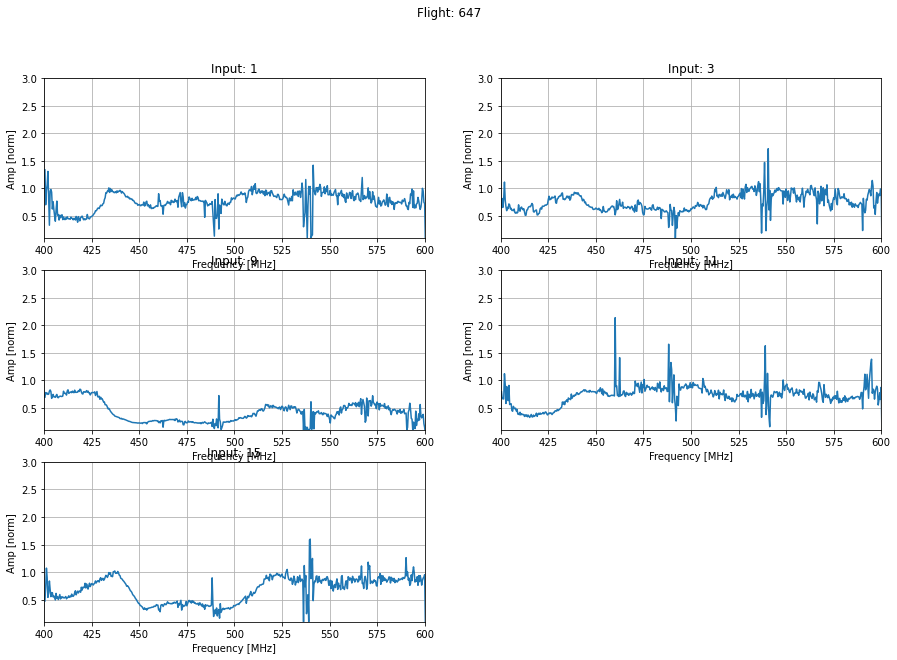

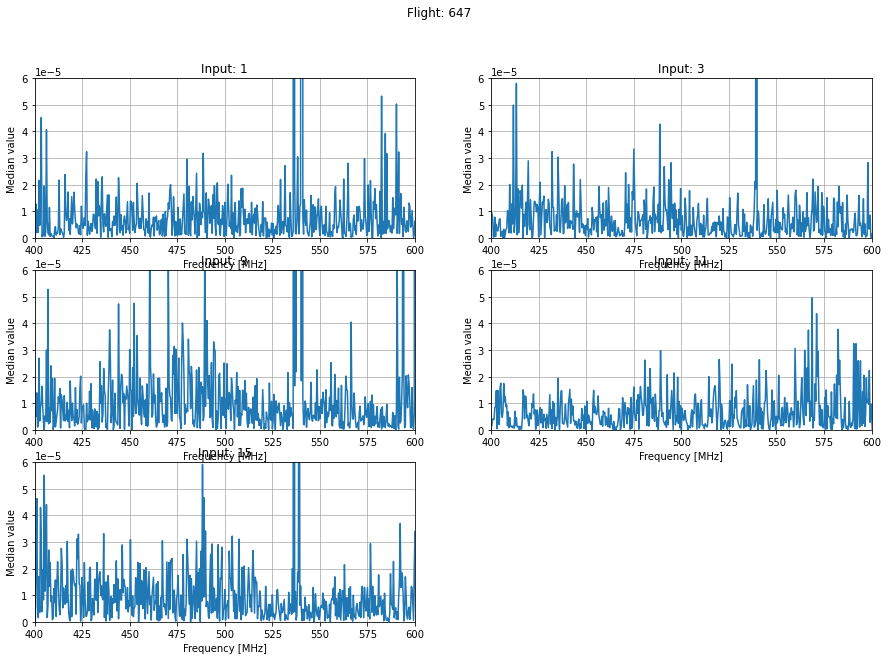

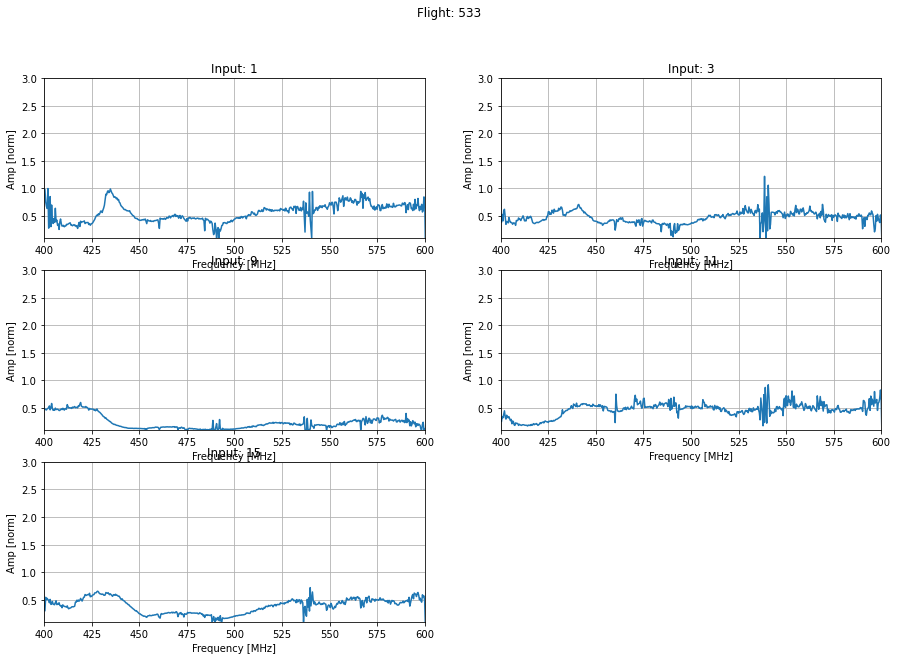

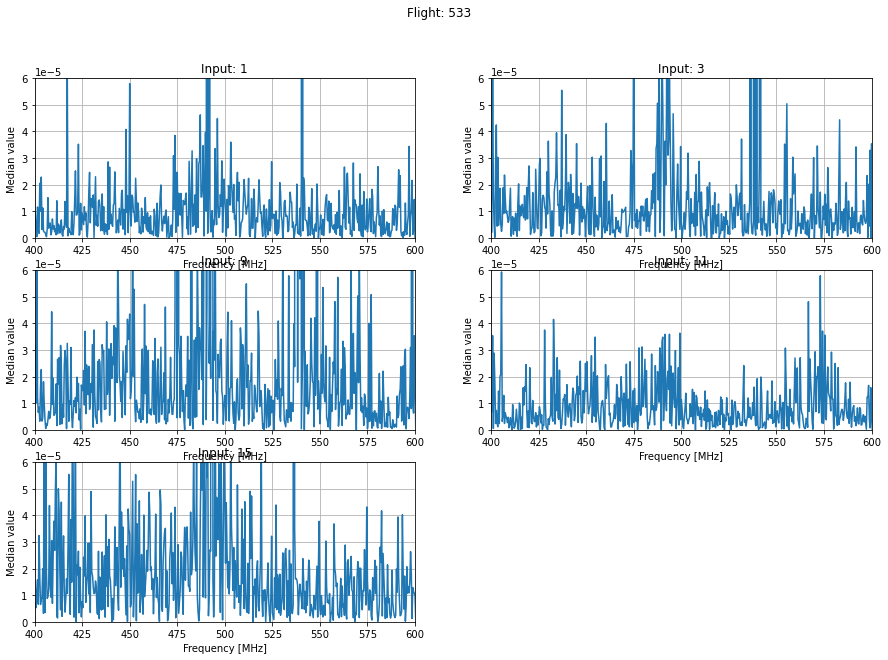

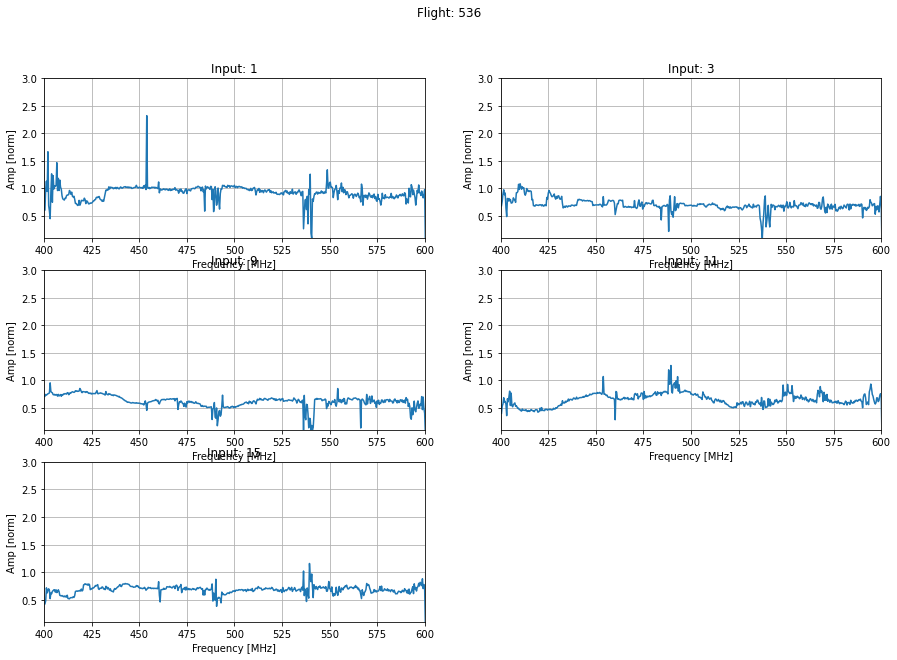

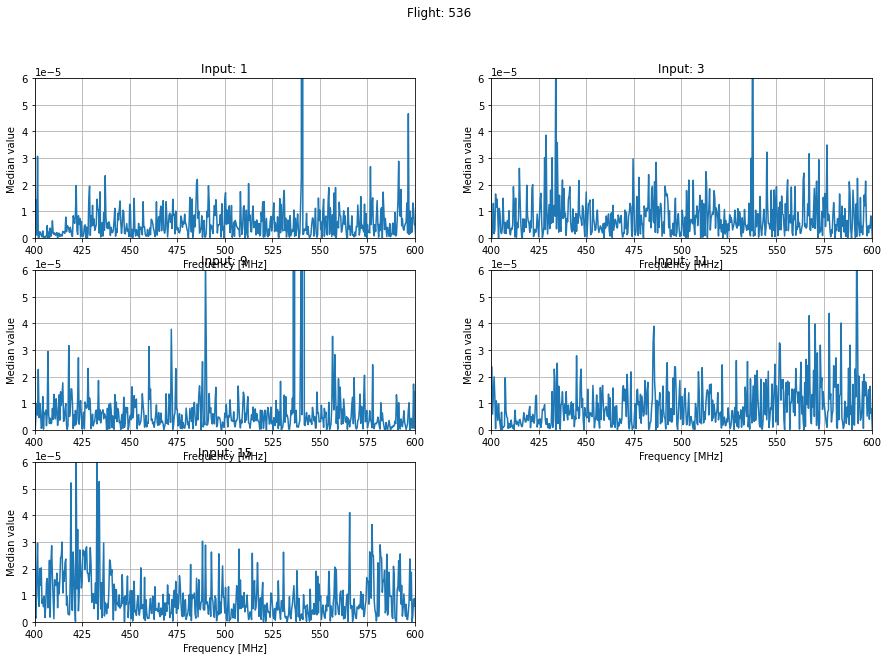

In [83]:
# Lets's start wi N pol:
pols = N_pols

for fly in Npolflights[1::]:
    amps = np.zeros([4,1024,16]) # stat [best amp value from median, median value at min, best from stdd, best from mean], freq, dish

    apkls = glob.glob(ampdir+'*618*'+fly+'*')
    for apkl in apkls:
        with open(apkl, 'rb') as inp:
            ampdata = pickle.load(inp)
        gfs = np.where(ampdata[0,:,pols[0]] != 0)
        amps[:,gfs,:] = ampdata[:,gfs,:]
        
    fig = plt.figure(figsize=(15,10))
    for j,chind in enumerate(pols):
        plt.subplot(3,2,j+1)
        plt.plot(freqs,amps[0,:,chind])
        plt.xlim(400,600)
        plt.ylim(0.1,3.0)
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Amp [norm]')
        plt.grid()
        plt.title('Input: '+str(chind))
    plt.suptitle('Flight: '+fly)
    plt.show()

    fig = plt.figure(figsize=(15,10))
    for j, chind in enumerate(pols):
        plt.subplot(3,2,j+1)
        plt.plot(freqs,amps[1,:,chind])
        plt.xlim(400,600)
        plt.ylim(0,6E-5)
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Median value')
        plt.grid()
        plt.title('Input: '+str(chind))
    plt.suptitle('Flight: '+fly)
    plt.show()
    
    for j, chind in enumerate(pols):
        for g in np.arange(512,1024):
            if amps[0,g,chind] == 0.1 or  amps[0,g,chind] >2.8 or amps[1,g,chind] >6E-5: Nbadfreqs.append(g)

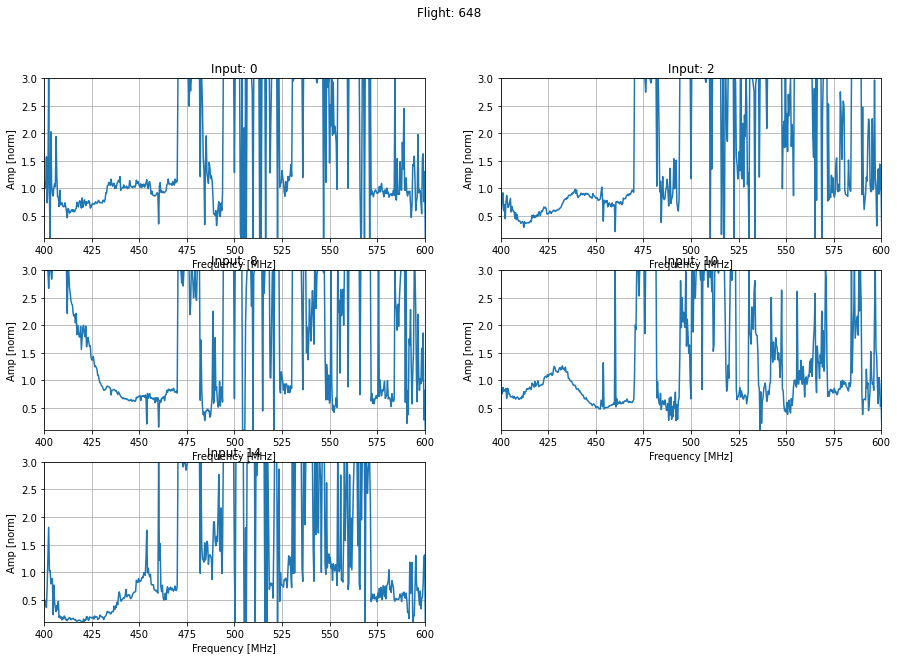

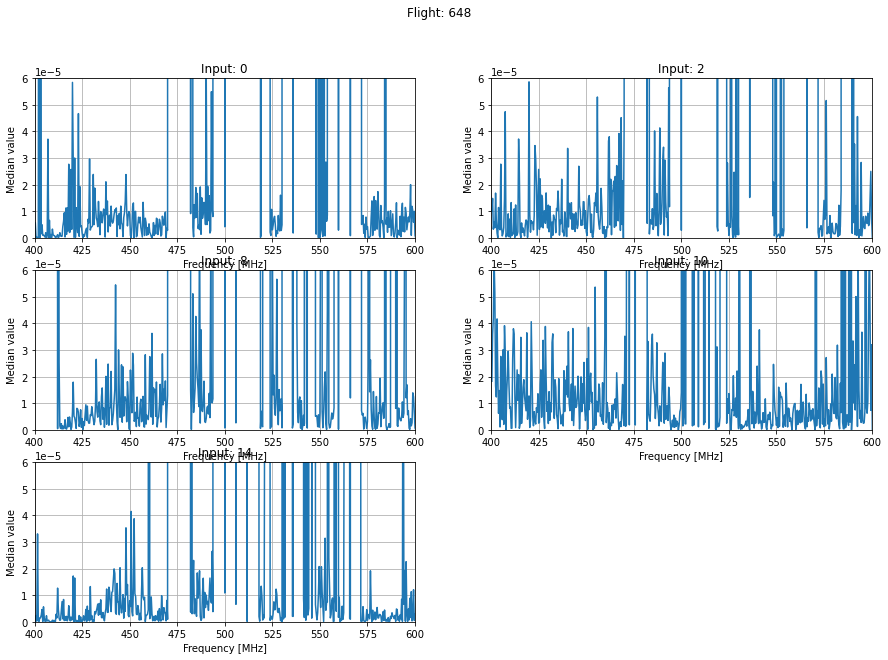

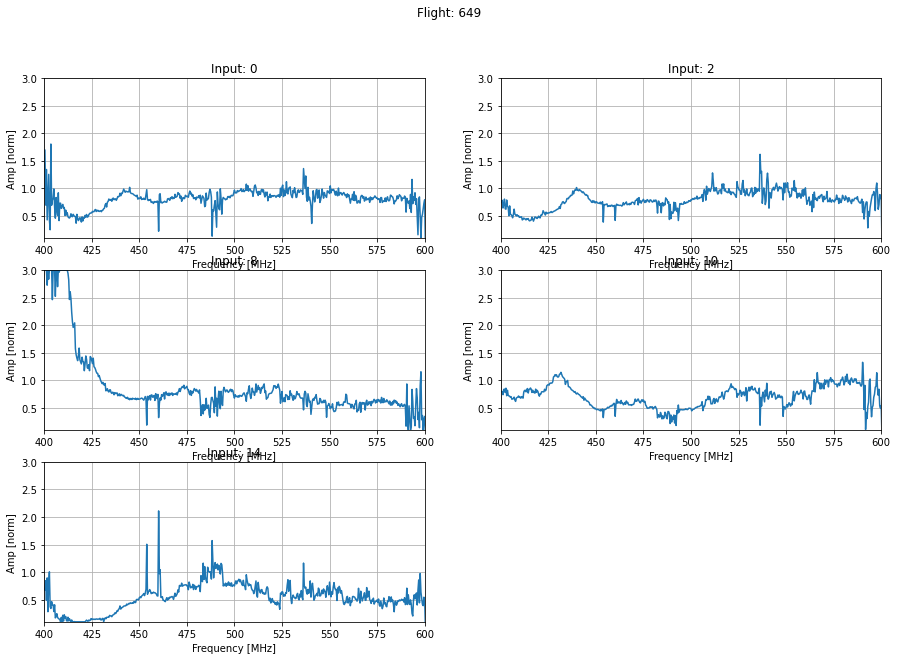

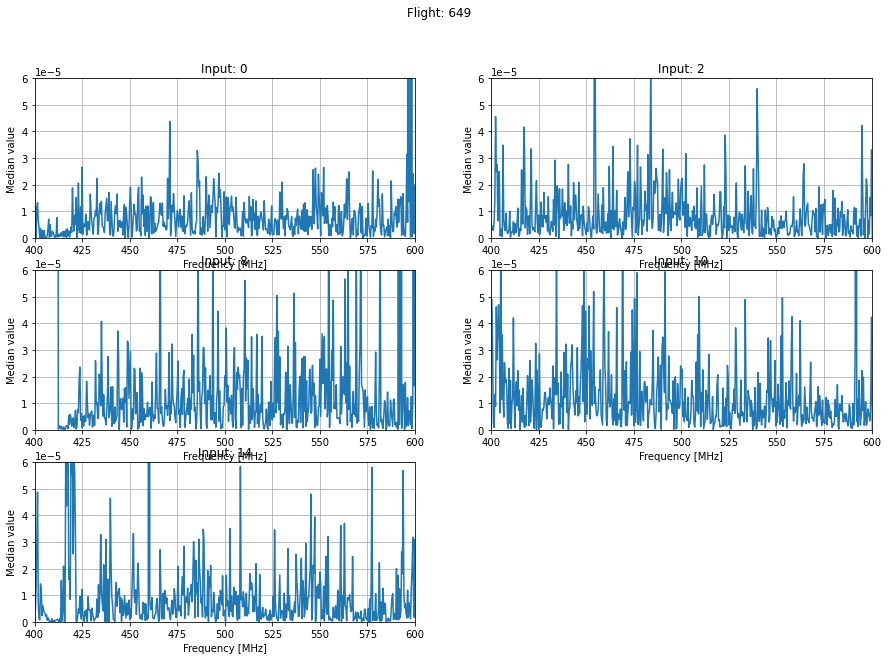

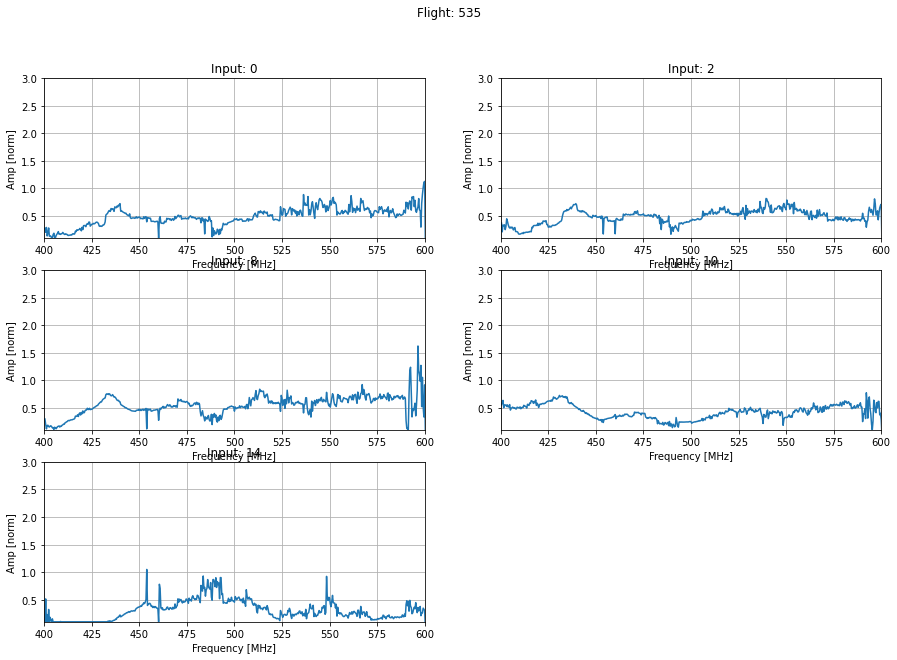

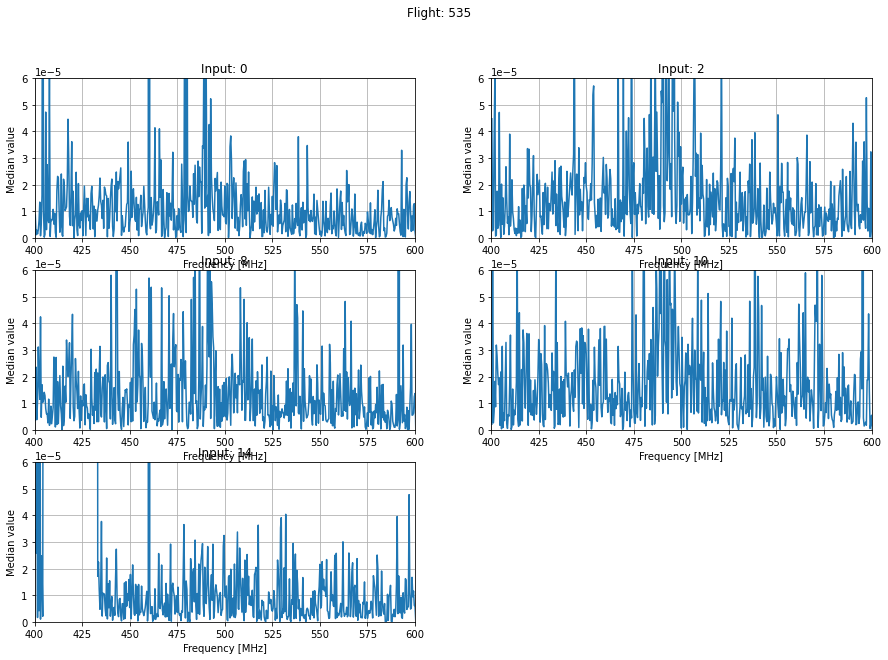

In [84]:
# Now E pol flights:
pols = E_pols

for fly in Epolflights[1::]:
    amps = np.zeros([4,1024,16]) # stat [best amp value from median, median value at min, best from stdd, best from mean], freq, dish

    apkls = glob.glob(ampdir+'*620*'+fly+'*')
    for apkl in apkls:
        with open(apkl, 'rb') as inp:
            ampdata = pickle.load(inp)
        gfs = np.where(ampdata[0,:,pols[0]] != 0)
        amps[:,gfs,:] = ampdata[:,gfs,:]
        
    fig = plt.figure(figsize=(15,10))
    for j,chind in enumerate(pols):
        plt.subplot(3,2,j+1)
        plt.plot(freqs,amps[0,:,chind])
        plt.xlim(400,600)
        plt.ylim(0.1,3.0)
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Amp [norm]')
        plt.grid()
        plt.title('Input: '+str(chind))
    plt.suptitle('Flight: '+fly)
    plt.show()

    fig = plt.figure(figsize=(15,10))
    for j, chind in enumerate(pols):
        plt.subplot(3,2,j+1)
        plt.plot(freqs,amps[1,:,chind])
        plt.xlim(400,600)
        plt.ylim(0,6E-5)
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Median value')
        plt.grid()
        plt.title('Input: '+str(chind))
    plt.suptitle('Flight: '+fly)
    plt.show()
    
    for j, chind in enumerate(pols):
        for g in np.arange(512,1024):
            if amps[0,g,chind] == 0.1 or  amps[0,g,chind] > 2.8 or amps[1,g,chind] >6E-5: Ebadfreqs.append(g)

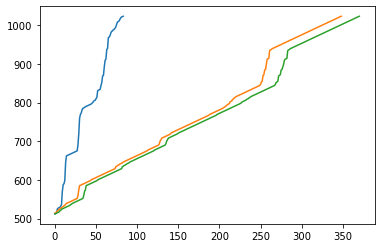

84 349 371
BAD FREQUENCY INDICES:  [ 512  513  514  515  516  517  520  521  524  525  526  527  528  529
  530  531  532  533  534  536  537  539  540  541  542  543  544  545
  546  547  548  549  550  551  552  559  570  574  585  586  587  588
  589  590  591  592  593  594  595  596  597  598  600  601  602  603
  604  605  606  607  608  609  610  611  612  613  614  615  616  617
  618  619  620  621  622  623  624  625  626  627  628  629  634  635
  637  638  639  641  642  643  644  646  647  648  649  650  651  652
  653  654  655  656  657  658  659  660  661  662  663  664  665  666
  667  668  669  670  671  672  673  674  675  677  678  679  680  681
  682  683  684  685  686  687  688  689  690  694  701  704  708  709
  710  711  712  713  714  715  716  717  718  719  721  722  723  724
  725  726  727  728  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  753  754  755  756  757  758  759  760  

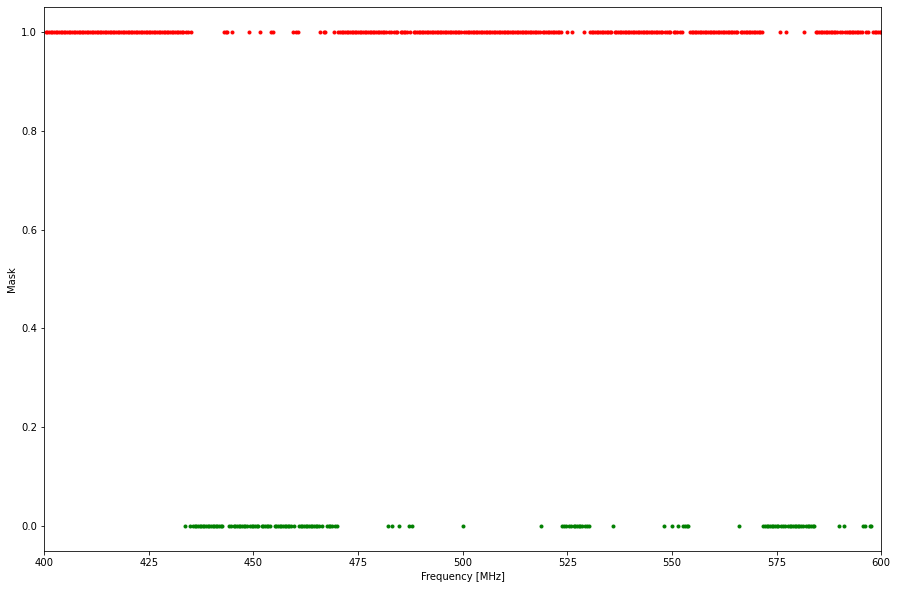

In [85]:
badfreqs = Nbadfreqs + Ebadfreqs

# get unique frequencies per array
uu = np.array(Nbadfreqs)
Nbad_uniq = np.unique(uu)

uu = np.array(Ebadfreqs)
Ebad_uniq = np.unique(uu)

uu = np.array(badfreqs)
bad_uniq = np.unique(uu)

plt.plot(Nbad_uniq)
plt.plot(Ebad_uniq)
plt.plot(bad_uniq)
plt.show()

print(len(Nbad_uniq),len(Ebad_uniq),len(bad_uniq))


freqm = np.zeros(1024)

freqm[bad_uniq] = 1.0

good_uniq = np.where(freqm==0.0)[0][512::]

fig = plt.figure(figsize=(15,10))
plt.plot(freqs[bad_uniq],freqm[bad_uniq],'r.')
plt.plot(freqs[good_uniq],freqm[good_uniq],'g.')
plt.xlim(400,600)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Mask')

print('BAD FREQUENCY INDICES: ',  bad_uniq)
print('GOOD FREQUENCY INDICES: ', good_uniq)



In [89]:
# compare this with the zeros in the waterfall from the raw data for flight 648

waterfall = [585,586,587, 588,  589,  590,  591,  592,  593,  594,  595,  596,  597,  598,
  600,  601,  602,  603,  604,  605,  606,  607,  608,  609,  610,  611,  612,  613,
  614,  616,  617,  618,  619,  620,  621,  622,  623,  624,  625,  626,  627,  628,
  629,  641,  643,  644,  647,  648,  649,  650,  651,  652,  653,  654,  655,  656,
  657,  658,  659,  660,  661,  662,  663,  664,  665,  666,  667,  668,  669,  670,
  671,  672,  673,  674,  675,  677,  678,  679,  680,  681,  682,  683,  684,  685,
  686,  687,  688,  689,  690,  708,  709,  710,  711,  712,  713,  714,  715,  716,
  717,  718,  721,  722,  723,  724,  725,  726,  727,  728,  729,  730,  731,  732,
  733,  734,  735,  736,  737,  738,  739,  740,  741,  742,  743,  744,  745,  746,
  747,  748,  749,  750,  751,  752,  753,  754,  755,  756,  757,  758,  759,  760,
  761,  762,  763,  764,  765,  766,  767,  769,  770,  771,  772,  773,  774,  775,
  776,  777,  778,  779,  780,  781,  782,  783,  811,  812,  813,  815,  816,  817,
  818,  819,  820,  821,  822,  823,  824,  825,  826,  827,  828,  829,  830,  831,
  832,  833,  834,  835,  836,  837,  838,  839,  840,  841,  842,  843,  844,  995,
  996,  998, 1001, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023]

In [91]:
picklezero = [ 540,  541,  542,  543,  544,  545,  546,  550,  552,  574,  585,  586,  587,  588,
  589,  590,  591,  592,  593,  594,  595,  596,  597,  598,  600,  601,  602,  603,
  604,  605,  606,  607,  608,  609,  610,  611,  612,  613,  614,  616,  617,  618,
  619,  620,  621,  622,  623,  624,  625,  626,  627,  628,  629,  638,  641,  643,
  646,  647,  648,  649,  650,  651,  652,  653,  654,  655,  656,  657,  658,  659,
  660,  661,  662,  663,  664,  665,  666,  667,  668,  669,  670,  671,  672,  673,
  674,  675,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,  687,  688,
  689,  690,  708,  709,  710,  711,  712,  713,  714,  715,  716,  717,  721,  722,
  723,  724,  725,  726,  727,  728,  729,  730,  731,  732,  733,  734,  735,  736,
  737,  738,  739,  740,  741,  742,  743,  744,  745,  746,  747,  748,  749,  750,
  751,  752,  753,  754,  755,  756,  757,  758,  759,  760,  761,  762,  763,  764,
  765,  766,  767,  769,  770,  771,  772,  773,  774,  775,  776,  777,  778,  779,
  780,  781,  782,  783,  797,  812,  813,  815,  816,  817,  818,  819,  820,  821,
  822,  823,  824,  825,  826,  827,  828,  829,  830,  831,  832,  833,  834,  835,
  836,  837,  838,  839,  840,  841,  842,  843,  844,  934,  936,  938,  939,  940,
  942,  943,  945,  946,  947,  948,  949,  950,  951,  952,  953,  954,  955,  956,
  957,  958,  959,  960,  961,  962,  963,  964,  965,  966,  967,  968,  969,  970,
  971,  972,  973,  974,  975,  976,  977,  978,  979,  980,  981,  982,  983,  984,
  985,  986,  987,  988,  989,  990,  991,  992,  993,  994,  995,  996,  997,  998,
  999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012,
 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023]

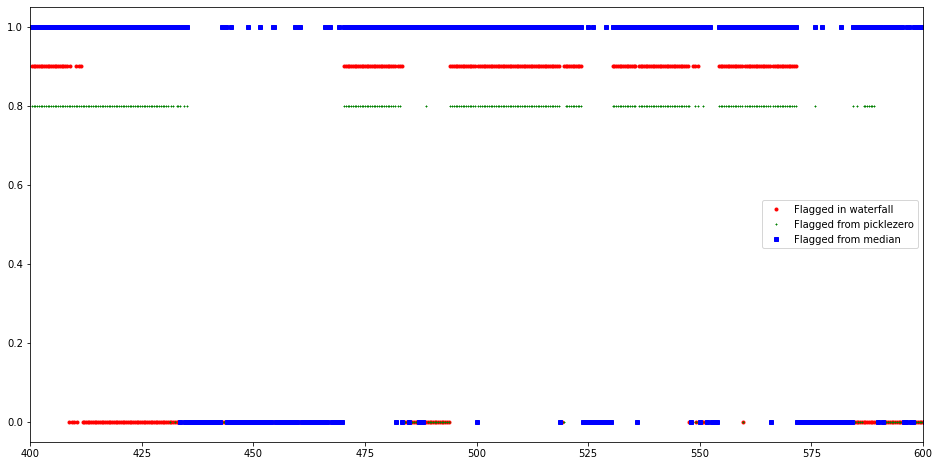

141


In [132]:
freqm = np.zeros(1024)
freqm[bad_uniq] = 1.0

freqw = np.zeros(1024)
freqw[waterfall] = 0.9

freqp = np.zeros(1024)
freqp[picklezero] = 0.8

fig = plt.figure(figsize=(16,8))
plt.plot(freqs,freqw,'ro',markersize=3,label='Flagged in waterfall')
plt.plot(freqs,freqp,'g+',markersize=2,label='Flagged from picklezero')
plt.plot(freqs,freqm,'bs',markersize=4,label='Flagged from median')
plt.xlim(400,600)
plt.legend()
plt.show()

print(len(good_uniq))

# Investigate various flight combinations
# --------------------------------------------------
# Keep for historical reasons: Look at flight differences from 618 or 620, compute median in annulus as a fucntion of freq

In [16]:
# Check out the normalizations getting applied
norms = np.zeros([1024,16,len(pflights)])
stats = np.zeros([1024,16,len(pflights)])
#norms = np.zeros([32,16,len(pflights)])
for i, fly in enumerate(pflights): 
    print(fly)
    if fly == '618': norms[:,:,i] = 1.0 
    elif fly == '620': norms[:,:,i] = 1.0 
    elif fly in Npolflights[1::]:
        pklfile = 'Flight_618'+'-Flight'+str(fly)+'_norms.pkl'
        print(pklfile)

        with open(pklfile, 'rb') as inp:
            fpstat = pickle.load(inp)
            #gdf = np.where(fpstat[0,:,chind]!=0)
        norms[:,:,i] = fpstat[0,:,:]
        stats[:,:,i] = fpstat[1,:,:]
    elif fly in Epolflights[1::]:
        print('in Epol flights')
        pklfile = 'Flight_620'+'-Flight'+str(fly)+'_norms.pkl'
        print(pklfile)

        with open(pklfile, 'rb') as inp:
            fpstat = pickle.load(inp)
            #gdf = np.where(fpstat[0,:,chind]!=0)
        norms[:,:,i] = fpstat[0,:,:]
        stats[:,:,i] = fpstat[1,:,:]




620
648
in Epol flights
Flight_620-Flight648_norms.pkl


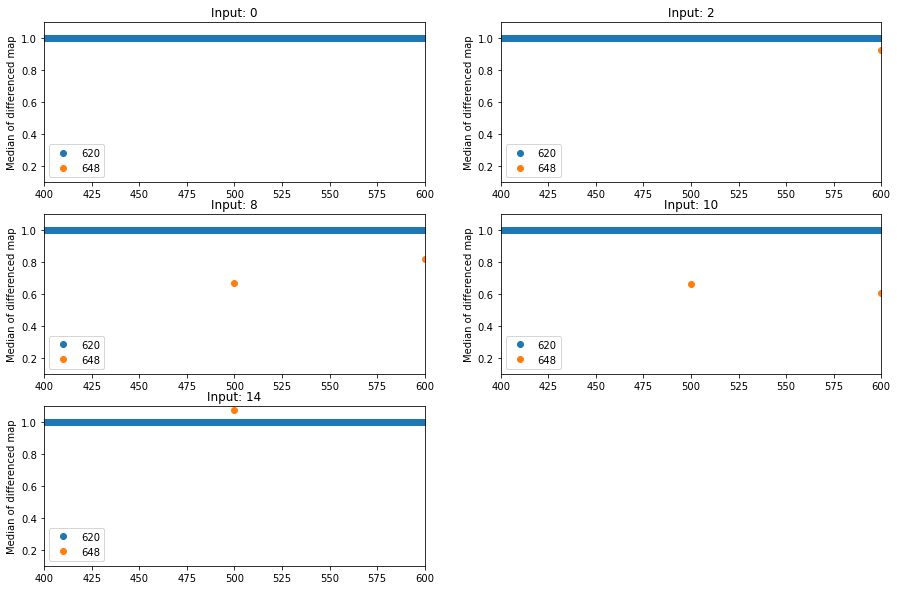

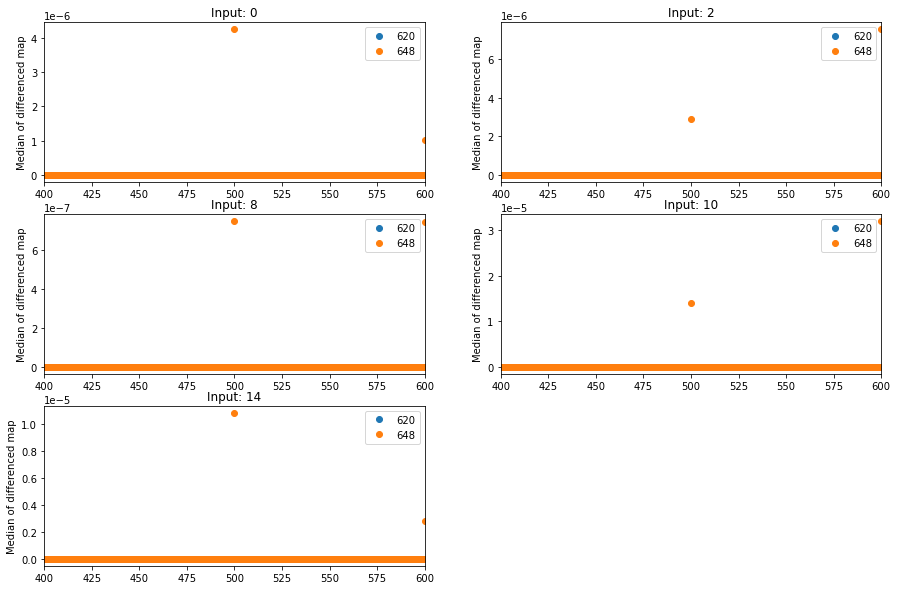

In [17]:
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(E_pols):
    plt.subplot(3,2,j+1)
    for i, fly in enumerate(pflights):
        plt.plot(freqs,norms[:,chind,i],marker='o',linestyle='None',label=str(fly))
        #plt.xlabel('Freq [MHz]')
        plt.ylabel('Median of differenced map')
        plt.grid()
        plt.title('Input: '+str(chind))
        plt.xlim(400,600)
        plt.ylim(0.1,1.1)
        plt.legend()
plt.show()     

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(E_pols):
    plt.subplot(3,2,j+1)
    for i, fly in enumerate(pflights):
        plt.plot(freqs,stats[:,chind,i],marker='o',linestyle='None',label=str(fly))
        #plt.xlabel('Freq [MHz]')
        plt.ylabel('Median of differenced map')
        plt.grid()
        plt.title('Input: '+str(chind))
        plt.xlim(400,600)
        #plt.ylim(0.1,1.1)
        plt.legend()
plt.show()     



In [18]:
print(stats[768,:,1])
print(norms[768,:,1])

[4.24635159e-06 0.00000000e+00 2.91412468e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.46133656e-07 0.00000000e+00 1.40458645e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.08171012e-05 0.00000000e+00]
[1.287 0.    1.178 0.    0.    0.    0.    0.    0.667 0.    0.661 0.
 0.    0.    1.074 0.   ]


In [9]:
# read in all files and apply normalization

flightarr = np.zeros([64,64,32,16,len(pflights)]) # pixel, pixel, freq, dish, Nflights
normarr = np.zeros([64,64,32,16,len(pflights)])

for i, fly in enumerate(pflights):
    
    pol, pols, cpols, attn, fi = get_flightinfo(fly)
    print(fly,pol,pols,cpols, attn)

    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
    print(concytest[fi])

    with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest1=pickle.load(pfile)
    t_cut=concattest1.inds_on    

    beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[512,1024,16],f_index=find,vplot=False)
    
    if fly == '618': 
        normarr[:,:,:,:,i] = 1.0
    elif fly == '620': 
        normarr[:,:,:,:,i] = 1.0
    elif fly in Npolflights[1::]:
        pklfile = 'Flight_618'+'-Flight'+str(fly)+'_norms.pkl'
        print(pklfile)

        with open(pklfile, 'rb') as inp:
            fpstat = pickle.load(inp)
        
        for d in np.arange(0,16):
            for f in np.arange(0,len(beam.faxis)):
                normarr[:,:,f,d,i] = fpstat[0,beam.faxis[f],d]
    elif fly in Epolflights[1::]:
        pklfile = 'Flight_620'+'-Flight'+str(fly)+'_norms.pkl'
        print(pklfile)

        with open(pklfile, 'rb') as inp:
            fpstat = pickle.load(inp)
        
        for d in np.arange(0,16):
            for f in np.arange(0,len(beam.faxis)):
                normarr[:,:,f,d,i] = fpstat[0,beam.faxis[f],d]
    
    print(fly, norm)
    flightarr[:,:,:,:,i] = beam.V_LC_mean[:,:,:,:,0]*normarr[:,:,:,:,i]


620 E [0, 2, 8, 10, 14] [1, 3, 9, 11, 15] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY620_20211021T192212Z_ver_20230412T224334_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY620_20211021T192212Z_ver_20230412T224334_concat.pkl'>
start of big ass loop is: 2023-05-24 12:47:48.889030
end of bigass loop is: 2023-05-24 12:48:11.604802     


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:273: RuntimeWarning: Mean of empty slice
  self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)


620 <matplotlib.colors.Normalize object at 0x7f6387f69190>
648 E [0, 2, 8, 10, 14] [1, 3, 9, 11, 15] 40
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY648_20211022T191922Z_ver_20230413T002159_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY648_20211022T191922Z_ver_20230413T002159_concat.pkl'>
start of big ass loop is: 2023-05-24 12:48:19.647469


KeyboardInterrupt: 

In [ ]:
#bfs = [736,832,592,752,816,806,656,672,688]
bfs = [592,608,656,688,736,752,816,832]
bfs = [544,592,608,624,656,672,688,736,752,816,832,960,976,992,1008]

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(E_pols):
    plt.subplot(3,2,j+1)
    for i, fly in enumerate(pflights):
        plt.plot(freqs[(beam.faxis)],normarr[0,0,:,chind,i],marker='o',linestyle='None',label=str(fly))
        #plt.xlabel('Freq [MHz]')
        plt.ylabel('Median of differenced map')
        plt.grid()
        plt.title('Input: '+str(chind))
        plt.xlim(400,600)
        plt.ylim(0.1,3.0)
        plt.legend()
        for bf in bfs:
            plt.axvline(freqs[bf],color='black')
plt.show() 

In [ ]:
## Create masks:

thingyx = np.ma.masked_inside(beam.x_centers_grid[:,:,chind], -1*maskin, maskin, copy=True)
thingyy = np.ma.masked_inside(beam.y_centers_grid[:,:,chind], -1*maskin, maskin, copy=True)
inner_mask = np.logical_and(thingyx.mask,thingyy.mask)

thingyx = np.ma.masked_inside(beam.x_centers_grid[:,:,chind], -1*maskout, maskout, copy=True)
thingyy = np.ma.masked_inside(beam.y_centers_grid[:,:,chind], -1*maskout, maskout, copy=True)
thingy = np.logical_and(thingyx.mask,thingyy.mask)
outer_mask = np.logical_not(thingy)

full_mask = np.logical_or(inner_mask,outer_mask)



In [ ]:
statarr = np.zeros([32,16,len(pflights)])

for i, fly in enumerate(pflights):
    print(fly)
    diff = flightarr[:,:,:,:,0] - flightarr[:,:,:,:,i]
    
    for d in np.arange(0,16):
        for f in np.arange(0,len(beam.faxis)):
            maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
            statarr[f,d,i] = get_stat(maskdiff,'mednoabs')


In [ ]:
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(pols):
    plt.subplot(3,2,j+1)
    for i, fly in enumerate(pflights):
        plt.plot(freqs[(beam.faxis)],statarr[:,chind,i],marker='o',alpha=0.6,label=str(fly))
        #plt.xlabel('Freq [MHz]')
        #plt.ylabel('Median of differenced map')
        plt.grid()
        plt.title('Input: '+str(chind))
        plt.ylim(-2E-3,2E-3)
        plt.legend()
plt.show()

# Epol flights only: combine into 46, 40, and 36dB flights, annulus mask, and compute/plot

In [ ]:
fly_46db = flightarr[:,:,:,:,0]
fly_40db = np.nanmean(flightarr[:,:,:,:,1:3],axis=-1)
fly_36db = flightarr[:,:,:,:,3]

In [ ]:
statarr = np.zeros([32,16,3])
itr = 0

for d in np.arange(0,16):
    for f in np.arange(0,32):
        # 46-40
        diff = fly_46db[:,:,:,:] - fly_40db[:,:,:,:]
        maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
        statarr[f,d,0] = get_stat(maskdiff,'mednoabs')
        # 46-36
        diff = fly_46db[:,:,:,:] - fly_36db[:,:,:,:]
        maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
        statarr[f,d,1] = get_stat(maskdiff,'mednoabs')
        # 40-36
        diff = fly_40db[:,:,:,:] - fly_36db[:,:,:,:]
        maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
        statarr[f,d,2] = get_stat(maskdiff,'mednoabs')

In [ ]:
pairs = ['46-40','46-36','40-36']

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(E_pols):
    plt.subplot(3,2,j+1)
    for i in range(0,3):
        plt.plot(freqs[(beam.faxis)],statarr[:,chind,i],marker='o',alpha=0.6,label=pairs[i])
        plt.xlabel('Freq [MHz]')
        plt.ylabel('Median of differenced map')
        plt.grid()
        plt.title('Input: '+str(chind))
        plt.ylim(-2E-3,2E-3)
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(E_pols):
    plt.subplot(3,2,j+1)
    for i in range(0,3):
        plt.semilogy(freqs[(beam.faxis)],np.abs(statarr[:,chind,i]),marker='o',alpha=0.6,label=pairs[i])
        plt.xlabel('Freq [MHz]')
        plt.ylabel('Median of differenced map')
        plt.grid()
        plt.title('Input: '+str(chind))
        plt.ylim(-2E-3,2E-3)
plt.legend()
plt.show()

In [ ]:
find=768#640#896#992#900#570#800#900
f_intern = int((find-512)/16)

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(E_pols):
    plt.subplot(3,2,j+1) 
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               fly_46db[:,:,f_intern,chind].T,cmap=cm.gnuplot2,vmax=1.1,vmin=0.001,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    plt.colorbar()
plt.suptitle('46dB flights')
plt.show()


fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(E_pols):
    plt.subplot(3,2,j+1) 
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               fly_40db[:,:,f_intern,chind].T,cmap=cm.gnuplot2,vmax=1.1,vmin=0.001,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    plt.colorbar()
plt.suptitle('40dB flights')
plt.show()

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(E_pols):
    plt.subplot(3,2,j+1) 
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               fly_36db[:,:,f_intern,chind].T,cmap=cm.gnuplot2,vmax=1.1,vmin=0.001,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    plt.colorbar()
plt.suptitle('36dB flights')
plt.show()

In [ ]:
for find in [528,576,704,720,768,784,800,848,864,880,896,928,944]:

    f_intern = int((find-512)/16)

    # take slice at x = 0
    xx = 0
    colx = get_slice(beam,beam.V_LC_mean[:,:,f_intern,chind,0],xx,'x')

    fig = plt.figure(figsize=(15,10))
    for j, chind in enumerate(E_pols):
        plt.subplot(3,2,j+1) 
        plt.semilogy(beam.y_centers_grid[:,colx,0],fly_46db[colx,:,f_intern,chind].T,'o',
             label='46dB  x :'+str(beam.x_centers_grid[0,colx,0]))
        plt.semilogy(beam.y_centers_grid[:,colx,0],fly_40db[colx,:,f_intern,chind].T,'o',
             label='40dB  x :'+str(beam.x_centers_grid[0,colx,0]))
        plt.semilogy(beam.y_centers_grid[:,colx,0],fly_36db[colx,:,f_intern,chind].T,'o',
             label='36dB  x :'+str(beam.x_centers_grid[0,colx,0]))
        plt.title('Input: '+str(chind))
        plt.ylim(0.0001,1)
        plt.xlim(-1*sz,sz)
    plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.legend()
    plt.show()

    xx = 0
    coly = get_slice(beam,beam.V_LC_mean[:,:,f_intern,chind,0],xx,'y')
    fig = plt.figure(figsize=(15,10))
    for j, chind in enumerate(E_pols):
        plt.subplot(3,2,j+1)
        plt.semilogy(beam.x_centers_grid[coly,:,0],fly_46db[:,coly,f_intern,chind].T,'o',
             label='46db y : '+str(beam.y_centers_grid[coly,0,0]))
        plt.semilogy(beam.x_centers_grid[coly,:,0],fly_40db[:,coly,f_intern,chind].T,'o',
             label='40db y : '+str(beam.y_centers_grid[coly,0,0]))
        plt.semilogy(beam.x_centers_grid[coly,:,0],fly_36db[:,coly,f_intern,chind].T,'o',
             label='36db y : '+str(beam.y_centers_grid[coly,0,0]))
        plt.ylim(0.0001,1)
        plt.xlim(-1*sz,sz)
        plt.title('Input: '+str(chind))
    plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.legend()
    plt.show()

# Npol flights only: Combine into 46, 43, 40, and 36dB flights, annulus mask, and compute median


In [ ]:
fly_46db = np.nanmean(flightarr[:,:,:,:,0:3],axis=-1)
fly_43db = flightarr[:,:,:,:,6]
fly_40db = np.nanmean(flightarr[:,:,:,:,3:5],axis=-1)
fly_36db = flightarr[:,:,:,:,5]

In [ ]:
statarr = np.zeros([32,16,6])
itr = 0

for d in np.arange(0,16):
    for f in np.arange(0,32):
        # 46-43
        diff = fly_46db[:,:,:,:] - fly_43db[:,:,:,:]
        maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
        statarr[f,d,0] = get_stat(maskdiff,'mednoabs')
        # 46-40
        diff = fly_46db[:,:,:,:] - fly_40db[:,:,:,:]
        maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
        statarr[f,d,1] = get_stat(maskdiff,'mednoabs')
        # 46-36
        diff = fly_46db[:,:,:,:] - fly_36db[:,:,:,:]
        maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
        statarr[f,d,2] = get_stat(maskdiff,'mednoabs')
        # 43-40
        diff = fly_43db[:,:,:,:] - fly_40db[:,:,:,:]
        maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
        statarr[f,d,3] = get_stat(maskdiff,'mednoabs')
        # 43-36
        diff = fly_43db[:,:,:,:] - fly_36db[:,:,:,:]
        maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
        statarr[f,d,4] = get_stat(maskdiff,'mednoabs')
        # 40-36
        diff = fly_40db[:,:,:,:] - fly_36db[:,:,:,:]
        maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
        statarr[f,d,5] = get_stat(maskdiff,'mednoabs')
        

In [ ]:
pairs = ['46-43','46-40','46-36','43-40','43-36','40-36']

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1)
    for i in range(0,6):
        plt.plot(freqs[gdf],statarr[:,chind,i],marker='o',alpha=0.6,label=pairs[i])
        #plt.xlabel('Freq [MHz]')
        #plt.ylabel('Median of differenced map')
        plt.grid()
        plt.title('Input: '+str(chind))
        plt.ylim(-2E-3,2E-3)
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1)
    for i in range(0,6):
        plt.semilogy(freqs[gdf],np.abs(statarr[:,chind,i]),marker='o',alpha=0.6,label=pairs[i])
        #plt.xlabel('Freq [MHz]')
        #plt.ylabel('Median of differenced map')
        plt.grid()
        plt.title('Input: '+str(chind))
        plt.ylim(-2E-3,2E-3)
plt.legend()
plt.show()

# Investigate differences between the 46dB flights


In [ ]:
flightarr = np.zeros([64,64,32,16,3]) # pixel, pixel, freq, dish, Nflights
find = 992

for i, fly in enumerate(Npolflights[0:3]):
    normarr = np.zeros([64,64,32,16])
    pol, pols, cpols, attn, fi = get_flightinfo(fly)
    print(fly,pol,pols,cpols, attn)

    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
    print(concytest[fi])

    with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest1=pickle.load(pfile)
    t_cut=concattest1.inds_on    

    beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[512,1024,16],f_index=find,vplot=False)
    
    if fly == '618': 
        normarr[:,:,:,:] = 1.0
    else:
        pklfile = 'Flight_618'+'-Flight'+str(fly)+'_norms.pkl'
        print(pklfile)

        with open(pklfile, 'rb') as inp:
            fpstat = pickle.load(inp)
        
        for d in np.arange(0,16):
            for f in np.arange(0,32):
                normarr[:,:,f,d] = fpstat[0,beam.faxis[f],d]
    
    print(fly, norm)
    flightarr[:,:,:,:,i] = beam.V_LC_mean[:,:,:,:,0]*normarr[:,:,:,:]


In [ ]:
diff1819 = flightarr[:,:,:,:,0] - flightarr[:,:,:,:,1]
diff1825 = flightarr[:,:,:,:,0] - flightarr[:,:,:,:,2]
diff1925 = flightarr[:,:,:,:,1] - flightarr[:,:,:,:,2]

high = 10 # inner mask, 20 for large flights
low = -10 # inner mask, 20 for large flights
maskin = high # annulus mask, set equal to high
maskout = 20 # annulus mask, 50 for large flights

## Create masks:

thingyx = np.ma.masked_inside(beam.x_centers_grid[:,:,chind], -1*maskin, maskin, copy=True)
thingyy = np.ma.masked_inside(beam.y_centers_grid[:,:,chind], -1*maskin, maskin, copy=True)
inner_mask = np.logical_and(thingyx.mask,thingyy.mask)

thingyx = np.ma.masked_inside(beam.x_centers_grid[:,:,chind], -1*maskout, maskout, copy=True)
thingyy = np.ma.masked_inside(beam.y_centers_grid[:,:,chind], -1*maskout, maskout, copy=True)
thingy = np.logical_and(thingyx.mask,thingyy.mask)
outer_mask = np.logical_not(thingy)

full_mask = np.logical_or(inner_mask,outer_mask)

# Look at inner masking for flight 625
statarr = np.zeros([32,16,3])

for d in np.arange(0,16):
    for f in np.arange(0,32):
            mask1819 = np.ma.masked_where(outer_mask, diff1819[:,:,f,d]).filled(np.nan)
            mask1825 = np.ma.masked_where(outer_mask, diff1825[:,:,f,d]).filled(np.nan)
            mask1925 = np.ma.masked_where(outer_mask, diff1925[:,:,f,d]).filled(np.nan)
            statarr[f,d,0] = get_stat(mask1819,'mednoabs')
            statarr[f,d,1] = get_stat(mask1825,'mednoabs')
            statarr[f,d,2] = get_stat(mask1925,'mednoabs')

In [ ]:
# useful to remember which frequencies I computed norms for...
gfr = np.where(fpstat[0,:,chind] !=0)[0]
print(gfr)
print(freqs[gfr],len(gfr))

In [ ]:
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1) 
    plt.plot(freqs[beam.faxis],statarr[:,chind,0],marker='o',label='Flight 1618 - 1619')
    plt.plot(freqs[beam.faxis],statarr[:,chind,1],marker='o',label='Flight 1618 - 1625')
    plt.plot(freqs[beam.faxis],statarr[:,chind,2],marker='o',label='Flight 1619 - 1625')
    plt.xlabel('Freq [MHz]')
    plt.ylabel('Median of differenced map')
    plt.title('Inner region only - 46dB flights')
    plt.grid()
plt.legend()
plt.show()

In [ ]:
# for 625 only, what would I get if I masked the inner region and minimized the nanmedian?

normspe = np.zeros([32,16])

for f in np.arange(0,32):
    for chind in N_pols:
        statarr = np.zeros(len(nss))
        for i in np.arange(0,len(nss)):
            ns = nss[i]
            diffn = get_beam_diff(flightarr[:,:,f,chind,0], flightarr[:,:,f,chind,2],ns)
            new_d = np.ma.masked_where(outer_mask, diffn).filled(np.nan)
            statarr[i] = get_stat(new_d,'median')

        mm = np.argmin(statarr)
        normspe[f,chind] = nss[mm]



In [ ]:
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1)
    plt.plot(freqs[gdf],normspe[:,chind],marker='o',label='Using inner region')
    plt.plot(freqs[gdf],norms[:,chind,2],marker='o',label='using annulus')
    plt.ylim(0.5,1.5)
    plt.legend()
    plt.title('Input '+str(chind))
plt.show()

# Investigate a single frequency

In [ ]:
find=640#896#992#900#570#800#900
ff = int((find - 512) / 16)

normflights = np.zeros([64,64,16,len(Npolflights)])

for i, fly in enumerate(Npolflights):
    
    pol, pols, cpols, attn, fi = get_flightinfo(fly)
    print(fly,pol,pols,cpols, attn)

    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
    print(concytest[fi])

    with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest1=pickle.load(pfile)
    t_cut=concattest1.inds_on    

    beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find-1,find+1,1],f_index=find,vplot=False)

    if fly == '618': norm = 1.0 
    else:
        pklfile = 'Flight_618'+'-Flight'+str(fly)+'_norms.pkl'
        print(pklfile)

        with open(pklfile, 'rb') as inp:
            fpstat = pickle.load(inp)
        norm = fpstat[0,find,:]
    print(fly, norm)
    normflights[:,:,:,i] = beam.V_LC_mean[:,:,f_intern,:,0]*norm

    #fig = plt.figure(figsize=(15,10))
    #for i,p in enumerate(pols):
    #    plt.subplot(3,2,i+1)
    #    plt.plot(freqs,fpstat[0,:,p],marker='.',linestyle='None',label='median')
    #    plt.plot(freqs,fpstat[1,:,p],marker='.',linestyle='None',label='stddev')
    #    plt.plot(freqs,fpstat[2,:,p],marker='.',linestyle='None',label='sum')
    #    plt.xlim(400,600)
    #    plt.ylim(0.1,1.5)
    #    plt.text(410,1.3,' Input: '+str(p))
    #    plt.axhline(1.0,color='black',ls='--')
    #plt.legend(loc='upper right')
    #plt.xlabel('frequency [MHz]')
    #plt.ylabel('Relative normalization')
    #plt.suptitle('Flights: '+fly1+' and '+fly2)
    #plt.show()



In [ ]:
# take slice at x = 0
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    xx = 0
    colx = get_slice(beam,beam.V_LC_mean[:,:,f_intern,chind,0],xx,'x')
    plt.subplot(3,2,j+1)
    for i, fly in enumerate(Npolflights):
        plt.semilogy(beam.y_centers_grid[:,colx,0],normflights[colx,:,chind,i].T,'o',
             label='Flight '+str(fly)+' x : '+str(beam.x_centers_grid[0,colx,0]))
    plt.title('Input: '+str(chind))
    plt.ylim(0.001,1)
    plt.xlim(-1*sz,sz)
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    xx = 0
    coly = get_slice(beam,beam.V_LC_mean[:,:,f_intern,chind,0],xx,'y')
    plt.subplot(3,2,j+1)
    for i, fly in enumerate(Npolflights):
        plt.semilogy(beam.x_centers_grid[coly,:,0],normflights[:,coly,chind,i].T,'o',
             label='Flight '+str(fly)+' y : '+str(beam.y_centers_grid[coly,0,0]))
    plt.ylim(0.001,1)
    plt.xlim(-1*sz,sz)
    plt.title('Input: '+str(chind))
plt.legend()
plt.show()

In [ ]:
# average similar attenuations together first

fly_46db = np.nanmean(normflights[:,:,:,0:3],axis=-1)
fly_43db = normflights[:,:,:,6]
fly_40db = np.nanmean(normflights[:,:,:,3:5],axis=-1)
fly_36db = normflights[:,:,:,5]

In [ ]:
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1) 
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               fly_46db[:,:,chind].T,cmap=cm.gnuplot2,vmax=1.1,vmin=0.001,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    plt.colorbar()
plt.suptitle('46dB flights')
plt.show()

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1) 
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               fly_43db[:,:,chind].T,cmap=cm.gnuplot2,vmax=1.1,vmin=0.001,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    plt.colorbar()
plt.suptitle('43dB flights')
plt.show()

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1) 
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               fly_40db[:,:,chind].T,cmap=cm.gnuplot2,vmax=1.1,vmin=0.001,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    plt.colorbar()
plt.suptitle('40dB flights')
plt.show()

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1) 
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               fly_36db[:,:,chind].T,cmap=cm.gnuplot2,vmax=1.1,vmin=0.001,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    plt.colorbar()
plt.suptitle('36dB flights')
plt.show()

In [ ]:
# take slice at x = 0
xx = 0
colx = get_slice(beam,beam.V_LC_mean[:,:,f_intern,chind,0],xx,'x')

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1) 
    plt.semilogy(beam.y_centers_grid[:,colx,0],fly_46db[colx,:,chind].T,'o',
             label='46dB  x :'+str(beam.x_centers_grid[0,colx,0]))
    plt.semilogy(beam.y_centers_grid[:,colx,0],fly_43db[colx,:,chind].T,'o',
             label='43dB  x :'+str(beam.x_centers_grid[0,colx,0]))
    plt.semilogy(beam.y_centers_grid[:,colx,0],fly_40db[colx,:,chind].T,'o',
             label='40dB  x :'+str(beam.x_centers_grid[0,colx,0]))
    plt.semilogy(beam.y_centers_grid[:,colx,0],fly_36db[colx,:,chind].T,'o',
             label='36dB  x :'+str(beam.x_centers_grid[0,colx,0]))
    plt.title('Input: '+str(chind))
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
plt.legend()
plt.show()

xx = 0
coly = get_slice(beam,beam.V_LC_mean[:,:,f_intern,chind,0],xx,'y')
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1)
    plt.semilogy(beam.x_centers_grid[coly,:,0],fly_46db[:,coly,chind].T,'o',
             label='46db y : '+str(beam.y_centers_grid[coly,0,0]))
    plt.semilogy(beam.x_centers_grid[coly,:,0],fly_43db[:,coly,chind].T,'o',
             label='43db y : '+str(beam.y_centers_grid[coly,0,0]))
    plt.semilogy(beam.x_centers_grid[coly,:,0],fly_40db[:,coly,chind].T,'o',
             label='40db y : '+str(beam.y_centers_grid[coly,0,0]))
    plt.semilogy(beam.x_centers_grid[coly,:,0],fly_36db[:,coly,chind].T,'o',
             label='36db y : '+str(beam.y_centers_grid[coly,0,0]))
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
    plt.title('Input: '+str(chind))
plt.legend()
plt.show()

In [ ]:
diff = get_beam_diff(fly_46db[:,:,chind], fly_43db[:,:,chind],1.0)

plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               np.abs(diff.T),cmap=cm.viridis,norm=LogNorm())#,edgecolors='k')
plt.xlim(-1*sz,sz)
plt.ylim(-1*sz,sz)
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.colorbar()
plt.show()

